### Pre-filtering for LightTag annotation

Setting up data for LighTag annotation: select 400 samples which are likely to contain PII from a set of 4000 random samples from 11 programming languages.

In [ ]:
from datasets import load_dataset, concatenate_datasets

nsamples = {'python': 800, 'c++': 800, 'javascript': 400, 'java': 400, 'typescript': 400, 'php': 400, 'c': 160, 'c-sharp': 160, 'markdown': 160, 'go': 160, 'ruby': 160}
languages = list(nsamples.keys())
# 4X the size of the original annotation dataset
seed = 41

ds = load_dataset("bigcode/the-stack-smol", data_dir="data/python/", split="train")
ds = ds.shuffle(seed=seed)
ds = ds.select(range(nsamples["python"]))

final_ds = ds

for lang in languages[1:]:
    ds = load_dataset("bigcode/the-stack-smol", data_dir=f"data/{lang}/", split="train")
    ds = ds.shuffle(seed=seed)
    ds = ds.select(range(nsamples[lang]))
    final_ds = concatenate_datasets([final_ds, ds])

final_ds = final_ds.remove_columns(['avg_line_length', 'max_line_length', 'alphanum_fraction'])
#final_ds.push_to_hub("pii_labeling_dataset_v2")

In [37]:
final_ds

Dataset({
    features: ['content', 'licenses', 'repository_name', 'path', 'size', 'lang'],
    num_rows: 5000
})

In [ ]:
from bigscience_pii_detect_redact import run_pii_batch
from functools import partial

ds_pii_bs = final_ds.map(
    partial(run_pii_batch),
    batched=True,
    batch_size=10,
    num_proc=12,
    load_from_cache_file=False
)

In [ ]:
ds_checks_bs = ds_pii_bs.filter(
    lambda exs: exs["modified"],
    batched=True,
    batch_size=10,
    num_proc=12
)

In [46]:
ds_checks_bs

Dataset({
    features: ['content', 'licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata', 'old_text', 'modified'],
    num_rows: 600
})

### Run dteect secrets on non selected samples

In [ ]:
from pii_detect_secrets import scan_str_content
import os

def scan_pii_batch(examples):
    pii = []
    has_pii = []
    for text in examples["content"]:
        output = scan_str_content(text, suffix=".txt")
        if  output:
            pii.append(repr(output))
            has_pii.append(True)
        else:
            pii.append("")
            has_pii.append(False)
    return {"pii": pii, "has_pii": has_pii}

ds_detect_secrets = final_ds.map(
    scan_pii_batch,
    batched=True,
    batch_size=10,
    num_proc=12,
    load_from_cache_file=False
)

In [ ]:
ds_checks_ds = ds_detect_secrets.filter(
    lambda exs: exs["has_pii"],
    batched=True,
    batch_size=10,
    num_proc=12,
)

In [57]:
ds_checks_ds

Dataset({
    features: ['content', 'licenses', 'repository_name', 'path', 'size', 'lang', 'pii', 'has_pii'],
    num_rows: 116
})

In [ ]:
ds_checks_ds['pii']

In [59]:
# global dataset
print(f"dataset detected with our regexes: {len(ds_checks_bs)}")
print(f"dataset detected with detect-secrets: {len(ds_checks_ds)}")

dataset detected with our regexes: 600
dataset detected with detect-secrets: 116


In [129]:
#list of 200 random numbers less than 600
import random
random_list = random.sample(range(0, 600), 400)
ds_checks_bs_small = ds_checks_bs.select(random_list)

In [130]:
ds_checks_bs_small

Dataset({
    features: ['content', 'licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata', 'old_text', 'modified'],
    num_rows: 400
})

In [131]:
# remove overlap between ds_checks_ds and ds_checks_bs base on paths
# keep files that aren't already in ds_checks_bs
union_ds = ds_checks_ds.filter(lambda exs: exs["path"] not in ds_checks_bs_small["path"])

  0%|          | 0/1 [00:00<?, ?ba/s]

In [133]:
ds_checks_ds

Dataset({
    features: ['content', 'licenses', 'repository_name', 'path', 'size', 'lang', 'pii', 'has_pii'],
    num_rows: 116
})

In [157]:
union_ds = union_ds.rename_column("pii", "regex_metadata")

In [163]:
ds_checks_bs_small

Dataset({
    features: ['licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata', 'content'],
    num_rows: 400
})

In [160]:
ds_checks_bs_small = ds_checks_bs_small.remove_columns(["content", "modified"])

In [162]:
ds_checks_bs_small = ds_checks_bs_small.rename_column("old_text", "content")

In [164]:
ds_checks_bs_small

Dataset({
    features: ['licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata', 'content'],
    num_rows: 400
})

In [166]:
union_ds = union_ds.remove_columns(["has_pii"])

In [167]:
union_ds

Dataset({
    features: ['content', 'licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata'],
    num_rows: 63
})

In [168]:
# concatenate the two datasets
concat_ds = concatenate_datasets([ds_checks_bs_small, union_ds])
concat_ds

Dataset({
    features: ['licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata', 'content'],
    num_rows: 463
})

In [ ]:
# remove pii columns
concat_ds = concat_ds.remove_columns(['pii', 'has_pii', 'modified', 'regex_metadata', 'content'])
union_ds.rename_column("pii", "regex_metadata")

In [ ]:
# we need to remove overlap with previously annotated files
annotated_dataset = load_dataset("data_lightag", split="train")

Remove overlap with already annotated samples in LightTag

In [97]:
# load json file
import json
with open('data_lightag/annotations.json') as f:
    labels = json.load(f)

In [77]:
#1000 examples
import json
with open('data_lightag/annotations.json') as f:
    labels = json.load(f)
print(f"level 0 format: {labels}, type, {type(labels)}, size: {len(labels)}")
print(f"level 1 format: {labels['examples'][0].keys()}, size: {len(labels['examples'][0])}")
print(labels["examples"][0]["annotations"][0].keys())

checked = 0
for i in range(len(labels["examples"])):
    seen = labels["examples"][i]["seen_by"]
    if seen:
        checked += 1
print(f"checked: {checked}")

dict_keys(['content', 'seen_by', 'metadata', 'example_id', 'annotations', 'classifications'])

In [78]:
labels["examples"][0]["annotations"][0].keys()

dict_keys(['end', 'tag', 'start', 'value', 'tag_id', 'correct', 'reviewed', 'example_id', 'annotated_by', 'definition_id', 'tagged_token_id'])

In [79]:
#1000 examples
labels["examples"][0]["annotations"]

[{'end': 115,
  'tag': 'NAME',
  'start': 102,
  'value': 'Matthew James',
  'tag_id': '9b5c5640-ead2-4583-8ca5-cb667536ab93',
  'correct': None,
  'reviewed': False,
  'example_id': '0000214e-1ad6-431b-a8c9-f03f219eb159',
  'annotated_by': [{'annotator': 'loubnabenallal1999@gmail.com',
    'timestamp': '2022-11-02T12:35:59.461+00:00',
    'annotator_id': 1}],
  'definition_id': '0844deb1-4f23-49d2-92f5-e50755635bef',
  'tagged_token_id': '465b55fa-04be-4547-8b32-ee816f920c2b'}]

In [98]:
checked = 0
for i in range(len(labels["examples"])):
    seen = labels["examples"][i]["seen_by"]
    if seen:
        checked += 1
print(f"checked: {checked}")

In [99]:
checked

180

In [111]:
# get list of paths of files that were checked from the dict labels
checked_paths = []
for i in range(1000):
    seen = labels["examples"][i]["seen_by"]
    if seen:
        #print(labels["examples"][i]["metadata"]["path"])
        checked_paths.append(labels["examples"][i]["metadata"]["path"])

In [112]:
len(checked_paths)

180

In [135]:
# remove files from concat_ds that have a path in checked_paths
concat_ds_filtered = concat_ds.filter(lambda exs: exs["path"] not in checked_paths)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [138]:
concat_ds_filtered

Dataset({
    features: ['content', 'licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata', 'old_text', 'modified', 'pii', 'has_pii'],
    num_rows: 455
})

In [137]:
concat_ds

Dataset({
    features: ['content', 'licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata', 'old_text', 'modified', 'pii', 'has_pii'],
    num_rows: 463
})

In [123]:
# remove 132 files from concat_ds_filtered if they aren't in ds_checks_ds
concat_ds_filtered2 = concat_ds_filtered.filter(lambda exs: exs["path"] not in ds_checks_ds["path"])
concat_ds_filtered2

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['content', 'licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata', 'old_text', 'modified', 'pii', 'has_pii'],
    num_rows: 510
})

In [171]:
# get list of paths in labels
labels_paths = []
for i in range(1000):
    labels_paths.append(labels["examples"][i]["metadata"]["path"])
# check if concat_ds_filtered2 has any paths in labels_paths
final_concat_ds = concat_ds.filter(lambda exs: exs["path"] not in labels_paths)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [215]:
user_pattern = r'''(?<=^|[)(\\s@,?!;:\'"\\p{Han}])(@[^)(\\s@,?!;:\'"]{3,})'''
user_pattern

'\n  (?<= ^ | [)(\\s@,?!;:\'"\\p{Han}] )\n  (@\n    [^)(\\s@,?!;:\'"]{3,}\n  )\n'

In [173]:
final_concat_ds.push_to_hub("pii_labeling_dataset_v2")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

In [207]:
# filter files with size higher than 5000
final_concat_ds2 = final_concat_ds.filter(lambda exs: exs["size"] < 45100)

Loading cached processed dataset at /Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-47d24a82622389e3/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-711a96a45ffb1669.arrow


In [208]:
final_concat_ds2.push_to_hub("pii_labeling_pre_filter")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

In [210]:
final_concat_ds2.to_json("pii_prefiltered.json", lines=False)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3858451

In [211]:
final_concat_ds2

Dataset({
    features: ['licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata', 'content'],
    num_rows: 400
})

In [149]:
# build new column that is regex_metadata if not empty or has_pii if not empty or both
def build_new_column(example):
    new_column = ""
    if example["has_pii"] is not None:
        new_column += example["pii"]
        print(f"pii {example['pii']}")
    if example["regex_metadata"] is not None:
        new_column += example["regex_metadata"]
    return {"pii_info": new_column}

concat_ds_filtered_f = concat_ds_filtered2.map(build_new_column)

  0%|          | 0/510 [00:00<?, ?ex/s]

In [109]:
# get distribution of each file extension from checked_paths
import os
from collections import Counter
exts = [os.path.splitext(path)[1] for path in checked_paths]
Counter(exts)

Counter({'.h': 6,
         '.cs': 6,
         '.py': 35,
         '.js': 16,
         '.ts': 20,
         '.php': 19,
         '.hpp': 9,
         '.cpp': 16,
         '.md': 8,
         '.cc': 4,
         '.java': 23,
         '.go': 5,
         '.rb': 8,
         '.tsx': 5})

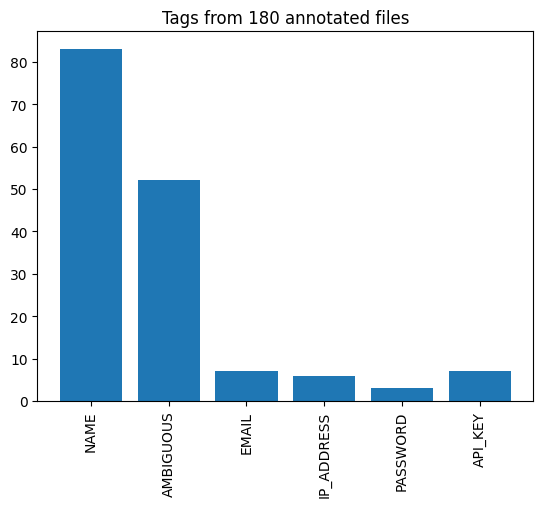

In [108]:
# get distribution of tags in annotations of labels
from collections import Counter
tags = []
for i in range(1000):
    for j in range(len(labels["examples"][i]["annotations"])):
        tags.append(labels["examples"][i]["annotations"][j]["tag"])
Counter(tags)
# plot distribution of tags
import matplotlib.pyplot as plt
plt.bar(Counter(tags).keys(), Counter(tags).values())
# add title to the plot saying tags from 180 annotated files
plt.title("Tags from 180 annotated files")
# rotate xlabels
plt.xticks(rotation=90)
# change bar color to light pink
plt.show()


In [ ]:
#redact emails only with bigscience regex this time
from redact_emails import run_pii_batch

ds_pii_mails = final_ds.map(
    partial(run_pii_batch),
    batched=True,
    batch_size=10,
    num_proc=12,
    load_from_cache_file=False
)

ds_checks_mails = ds_pii_mails.filter(
    lambda exs: exs["modified"],
    batched=True,
    batch_size=10,
    num_proc=12
)

In [47]:
ds_checks_mails
# way too many false positives

Dataset({
    features: ['content', 'licenses', 'repository_name', 'path', 'size', 'lang', 'regex_metadata', 'old_text', 'modified'],
    num_rows: 1261
})